# Point spread function using Tiny Tim/Galfit

Calling tinytim to generate psf is realized by .py script modified from Bryan R. Gillis, the following infomation is required:

0. sensor name

1. detector position

2. wavelengths of the emission lines (redshift)

3. subsampled factor

4. (optional) filter used and focus info



### import modules and defing a few useful little functions

In [1]:
import psf.make_psf as tinytim
import  numpy               as     np
from    astropy.table       import Table
from    astropy.io          import fits
from    scipy.ndimage       import rotate
#from    astropy.cosmology   import Planck18
#import  astropy.units       as     u
import  matplotlib.pyplot   as     plt
import  matplotlib.colors   as     colors  
from    matplotlib          import use
from    tqdm.auto                import tqdm
from concurrent.futures     import ThreadPoolExecutor, as_completed
import sys, os
from IPython.display import clear_output
from scripts.tools   import *
import re

tinytim_path = '/Users/yangcheng/tinytim-7.5'  # 正确的 tinytim 路径
obj_lis = Table.read('obj_lis_selected.fits')
print(len(obj_lis))

553


### generate psf by calling tinytim + rotation and crop

In [5]:
def rotate_and_crop(image_path,rotating_angle=0,crop_size=30):
    with fits.open(image_path) as hdu:

        rot = rotate(hdu[0].data, 
                    angle=rotating_angle, 
                    reshape=False, 
                    mode='constant')
        
        center_x, center_y = np.array(hdu[0].data.shape) // 2
        half_crop = crop_size // 2
        cropped_data = rot[
            center_y - half_crop : center_y + half_crop,
            center_x - half_crop : center_x + half_crop]
        image = fits.ImageHDU(data=cropped_data, header=hdu[0].header)
    return image

#using tinytim and rotate to generate single psf
def gen_psf(obj,exist_skip=False):
   # try:
        # Ensure directories exist before writing files
        os.makedirs('psf/individual_psf', exist_ok=True)
        os.makedirs('psf/combined_psf', exist_ok=True)
        #path to save individual psf and combined psf
        save_path          = f"psf/individual_psf/{obj['subfield']}_{obj['id']}"
        save_path_combined = f"psf/combined_psf/{obj['subfield']}_{obj['id']}"
        clear_output(wait=True)
        #check if files already exist
        #if os.path.exists(f"{save_path}_psf.fits") and os.path.exists(f"{save_path_combined}_ha.fits") and os.path.exists(f"{save_path_combined}_hb.#fits"):
        #    clear_output(wait=True)
        #    return f"{obj['subfield']}_{obj['id']} already exists"
        #else:
        #    print(f"Processing {obj['subfield']}_{obj['id']}")
        #load parameter table
        param_table = Table.read(f"psf/obj_param/{obj['subfield']}_{obj['id']}_psf.fits")
        #use integration time as weight
        int_time = np.array(param_table['DELTATIM'])
        weights = int_time/np.sum(int_time)
        #psf_lis to contain individual psf
        psf_lis = fits.HDUList(); psf_lis.append(fits.PrimaryHDU())
        #_combine to store weighted average
        ha_combine = fits.ImageHDU(data=np.zeros((30,30)));hb_combine = fits.ImageHDU(data=np.zeros((30,30)))
        
        #calculate for each individual beam file:
        for i,row in tqdm(enumerate(param_table)):
            print(row)
            identifier, rootname, pad, filter, pa ,focus, coord_ha, coord_hb, wavelen_ha, wavelen_hb, deltatim = row

    #------------------this part generate and rotate individual psf--------------------------------
            #ha
            filename_ha = f"psf/individual_psf/{identifier.split('_')[2]}_ha.fits"
            tinytim.make_subsampled_model_psf(filename=filename_ha,
                                psf_size = 4,
                                filter_name = filter,
                                focus = focus,  
                                psf_position = coord_ha,
                                mono = wavelen_ha,
                                subsampling_factor = 1,
                                tinytim_path = tinytim_path,
                                exist_skip=False)
            ha_psf = rotate_and_crop(filename_ha,-pa)
            ha_psf.name= f'{rootname}_ha'
            ha_combine.data += ha_psf.data * weights[i]
            
            #hb
            filename_hb = f"psf/individual_psf/{identifier.split('_')[2]}_hb.fits"
            tinytim.make_subsampled_model_psf(filename=filename_hb,
                                psf_size = 4,
                                filter_name = filter,
                                focus = focus,  
                                psf_position = coord_hb,
                                mono = wavelen_hb,
                                subsampling_factor = 1,
                                tinytim_path = tinytim_path,
                                exist_skip=False)
            hb_psf = rotate_and_crop(filename_hb,-pa)
            hb_psf.name = f'{rootname}_hb'
            hb_combine.data += hb_psf.data * weights[i]
    #----------------------------------------------------------------------------------------------

            #normalization and append individual psf
            ha_psf.data = ha_psf.data/np.sum(ha_psf.data)
            hb_psf.data = hb_psf.data/np.sum(hb_psf.data)
            psf_lis.append(ha_psf);psf_lis.append(hb_psf)
            os.remove(filename_ha);os.remove(filename_hb)

        #save combined & individual psf
        psf_lis.append(ha_combine);psf_lis.append(hb_combine)
        psf_lis.writeto(f'{save_path}_psf.fits',overwrite=True)
        ha_combine.writeto(f'{save_path_combined}_ha.fits',overwrite=True)
        hb_combine.writeto(f'{save_path_combined}_hb.fits',overwrite=True)

        #clear output and return
        clear_output(wait=True)
        return f"{obj['subfield']}_{obj['id']} processed"

    #except Exception as e:
    #    print(f"Error processing {obj['subfield']}_{obj['id']}: {e}")
    #    return f"! {obj['subfield']}-{obj['ID']} failed, error:{e}" 
    print('total number of obj processed:',len(results))
    print('number of failed obj',number)

total number of obj processed: 2
number of failed obj 0


In [20]:
error_table = Table.read('failed_objects.fits')
print('errored objects, potential data problem from the sever (bad data set)')
print(error_table)

#remove error objects from obj_lis
obj_lis = Table.read('obj_lis_selected.fits')
print('number of objects before removing errored objects:', len(obj_lis))

#remove errored objects from obj_lis
errored_ids = error_table['ID']
errored_subfields = error_table['subfield']
mask = np.ones(len(obj_lis), dtype=bool)
for i, row in enumerate(obj_lis):
    if (str(row['ID']) in errored_ids.astype(str)) and (str(row['subfield']) in errored_subfields.astype(str)):
        mask[i] = False
obj_lis = obj_lis[mask]
print('number of objects after removing errored objects:', len(obj_lis))
obj_lis.write('obj_lis_selected.fits', overwrite=True)

errored objects, potential data problem from the sever (bad data set)
subfield ...
-------- ...
     GN7 ...
number of objects before removing errored objects: 545
number of objects after removing errored objects: 545


In [10]:
tinytim_path = '/Users/yangcheng/tinytim-7.5'  #tinytimpath
from scripts.make_wcs_header import make_wcsheader
from astropy.wcs import WCS
from   drizzlepac        import adrizzle
drizzler = adrizzle.do_driz

def find_filter_for_ha_hb(redshift):
    '''
    Find the appropriate filter for the given redshift for both HA and HB lines. for g102 g141
    '''
    ha_obs, hb_obs = np.array([656.28,486.13]) * (1+redshift) 
    ha_filter = []; hb_filter = []
    if ha_obs  < 1150:
        ha_filter.append('G102')
    if ha_obs > 1075:
        ha_filter.append('G141')
    if hb_obs  < 1150:
        hb_filter.append('G102')
    if hb_obs > 1075:
        hb_filter.append('G141')
    return {'ha':ha_filter, 'hb':hb_filter}

def gen_and_drizzle_psfs(obj):
    '''
    this section generates tinytim psf for individual observations:
    with unique pixel coordinates, pas, and wavelength for Ha or Hb
    '''

    if os.path.exists(f"psf/combined_psf/{obj['subfield']}_{obj['id']}_ha.fits") and os.path.exists(f"psf/combined_psf/{obj['subfield']}_{obj['id']}_hb.fits"):
        #clear_output(wait=True)
        print(f"{obj['subfield']}_{obj['id']} already exists")
        return
    filter_dict_for_line = find_filter_for_ha_hb(obj['z_MAP'])
    beam_path = f"data_products/{file_name(obj,'beams')}"
    ha_psf_lis = fits.HDUList(); ha_psf_lis.append(fits.PrimaryHDU())
    hb_psf_lis = fits.HDUList(); hb_psf_lis.append(fits.PrimaryHDU())
    drizzled_psf_lis = fits.HDUList(); drizzled_psf_lis.append(fits.PrimaryHDU())
    wcs_ha_lis = []; wcs_hb_lis = []
    int_time_ha = []; int_time_hb = []

    print(f"Generating PSFs for {obj['subfield']}_{obj['id']} with filters {filter_dict_for_line}")
    with fits.open(beam_path) as hdul:
        for image in hdul:
            if image.name == 'SCI':

                #image basic information:
                coord = (image.header['ORIGINX'] - image.header['PAD'] + image.header['NAXIS1']//2,
                         image.header['ORIGINY'] - image.header['PAD'] + image.header['NAXIS2']//2)
                identifier = f"{obj['subfield']}_{obj['id']}_{image.header['ROOTNAME']}"
                rootname = image.header['ROOTNAME']
#------------------------------------------------------------
                print(f"Processing {identifier} with filter {image.header['FILTER']}")
                #now generate mono psf for both ha hb
                if image.header['FILTER'] in filter_dict_for_line['ha']:
                    int_time_ha.append(image.header['DELTATIM'])
                    filename_ha = f"psf/individual_psf/{identifier.split('_')[2]}_ha.fits"
                    tinytim.make_subsampled_model_psf(filename=filename_ha,
                                psf_size = 6,
                                filter_name = filter,
                                focus = -0.14,  
                                psf_position = coord,
                                mono = 656.28*(1+obj['z_MAP']),
                                subsampling_factor = 1,
                                tinytim_path = tinytim_path,
                                exist_skip=False)
                    with fits.open(filename_ha) as hdu_ha:
                        ha_psf = fits.ImageHDU(data=hdu_ha[0].data, header=hdu_ha[0].header)
                        modified_header, wcs_ha = make_wcsheader(
                            ra = obj['ra'], 
                            dec = obj['dec'], 
                            size = ha_psf.header['PIXSCALE']*ha_psf.header['NAXIS1'], 
                            pixscale = ha_psf.header['PIXSCALE'], 
                            theta = image.header['PA_APER'])  # 使用实际的PA角度
                        wcs_ha_lis.append(WCS(modified_header))
                        #update header with WCS info, preserving required FITS keywords
                        ha_psf.header.update(modified_header)
                        ha_psf.name = f'{rootname}_ha'
                        ha_psf_lis.append(ha_psf)
                    os.remove(filename_ha)
                    
                if image.header['FILTER'] in filter_dict_for_line['hb']:
                    int_time_hb.append(image.header['DELTATIM'])
                    filename_hb = f"psf/individual_psf/{identifier.split('_')[2]}_hb.fits"
                    tinytim.make_subsampled_model_psf(filename=filename_hb,
                                psf_size = 6,
                                filter_name = filter,
                                focus = -0.14,  
                                psf_position = coord,
                                mono = 486.13*(1+obj['z_MAP']),
                                subsampling_factor = 1,
                                tinytim_path = tinytim_path,
                                exist_skip=False)
                    with fits.open(filename_hb) as hdu_hb:
                        hb_psf = fits.ImageHDU(data=hdu_hb[0].data, header=hdu_hb[0].header)
                        modified_header, wcs_hb = make_wcsheader(
                            ra = obj['ra'], 
                            dec = obj['dec'], 
                            size = hb_psf.header['PIXSCALE']*hb_psf.header['NAXIS1'], 
                            pixscale = hb_psf.header['PIXSCALE'], 
                            theta = image.header['PA_APER'])
                        wcs_hb_lis.append(WCS(modified_header))
                        #update header with WCS info, preserving required FITS keywords
                        hb_psf.header.update(modified_header)
                        hb_psf.name = f'{rootname}_hb'
                        hb_psf_lis.append(hb_psf)
                    os.remove(filename_hb)

#------------------------------------------------------------
        # now this part is used to drizzle psfs together
    print('Starting to drizzle PSFs together...')
    fullfits_path = f"data_extracted/{file_name(obj, prefix='extracted')}"
    with fits.open(fullfits_path) as hdul:
        ha_drizzled = find_data('LINE_HA',hdul)[1]
        output_shape = (30,30)#(ha_psf_lis[1].data.shape / 1.5)
        target_header,target_wcs = make_wcsheader(
                        ra = obj['ra'], 
                        dec = obj['dec'], 
                        size = output_shape[0]*ha_drizzled.header['PIXASEC'], 
                        pixscale = ha_drizzled.header['PIXASEC'], 
                        theta = 0)
        #target_wcs = WCS(target_header)
        combined_ha = np.zeros(output_shape, dtype=np.float32)
        combined_hb = np.zeros(output_shape, dtype=np.float32)

        weight_maps = np.ones_like(ha_psf_lis[1].data)  # Assuming uniform weights for simplicity
        weight_ha = np.array(int_time_ha) / np.sum(int_time_ha)
        weight_hb = np.array(int_time_hb) / np.sum(int_time_hb)
        for i, (ha, ha_wcs, hb, hb_wcs) in enumerate(zip(ha_psf_lis[1:], wcs_ha_lis, hb_psf_lis[1:], wcs_hb_lis)):
            # 为每次drizzle创建新的临时数组
            print(f"Drizzling PSF {i+1}/{len(ha_psf_lis)-1}")
            temp_ha_single =     np.zeros(output_shape, dtype=np.float32)
            temp_ha_wht_single = np.zeros(output_shape, dtype=np.float32)
            temp_ha_con_single = np.zeros(output_shape, dtype=np.int32)
            temp_hb_single =     np.zeros(output_shape, dtype=np.float32)
            temp_hb_wht_single = np.zeros(output_shape, dtype=np.float32)
            temp_hb_con_single = np.zeros(output_shape, dtype=np.int32)
            
            adrizzle.do_driz(
                        insci= ha.data,
                        input_wcs= ha_wcs,
                        inwht= weight_maps,
                        output_wcs= target_wcs,
                        outsci=temp_ha_single,
                        outwht=temp_ha_wht_single,
                        outcon=temp_ha_con_single,
                        in_units='cps',
                        expin=1.0,
                        wt_scl=1.0,
                        wcslin_pscale=1,
                        pixfrac=0.8,#ha_drizzled.header['PIXFRAC'],
                        kernel='square',
                        fillval=0.0)
            
            adrizzle.do_driz(
                        insci= hb.data,
                        input_wcs= hb_wcs,
                        inwht= weight_maps,
                        output_wcs= target_wcs,
                        outsci=temp_hb_single,
                        outwht=temp_hb_wht_single,
                        outcon=temp_hb_con_single,
                        in_units='cps',
                        expin=1.0,
                        wt_scl=1.0,
                        wcslin_pscale=1,
                        pixfrac=0.8,#ha_drizzled.header['PIXFRAC'],
                        kernel='square',
                        fillval=0.0)
            
            combined_ha += temp_ha_single * weight_ha[i]
            combined_hb += temp_hb_single * weight_hb[i]

        save_path_combined = f"psf/combined_psf/{obj['subfield']}_{obj['id']}"
        save_path          = f"psf/individual_psf/{obj['subfield']}_{obj['id']}"
        ha_drizzled = fits.ImageHDU(data=combined_ha)
        ha_drizzled.header.update(target_header)
        hb_drizzled = fits.ImageHDU(data=combined_hb)
        hb_drizzled.header.update(target_header)
        ha_drizzled.writeto(f'{save_path_combined}_ha.fits',overwrite=True)
        hb_drizzled.writeto(f'{save_path_combined}_hb.fits',overwrite=True)
        ha_psf_lis.writeto(f'{save_path}_ha.fits', overwrite=True)
        hb_psf_lis.writeto(f'{save_path}_hb.fits', overwrite=True)
        
for obj in tqdm(obj_lis):
    try:
        clear_output(wait=True)
        gen_and_drizzle_psfs(obj)
    except Exception as e:
        print(f"Error generating PSFs for {obj['subfield']}-{obj['id']}: {e}")

Generating PSFs for GS4_25197 with filters {'ha': ['G141'], 'hb': ['G102', 'G141']}
Processing GS4_25197_icoi1mjxq with filter G102
Processing GS4_25197_icoi1mk0q with filter G102
Processing GS4_25197_icoi1mk2q with filter G102
Processing GS4_25197_icoi1mk6q with filter G102
Processing GS4_25197_icoi1mkcq with filter G102
Processing GS4_25197_icoi1mkfq with filter G102
Processing GS4_25197_icoi1mkhq with filter G102
Processing GS4_25197_icoi1mklq with filter G102
Processing GS4_25197_icoi1ng2q with filter G102
Processing GS4_25197_icoi1ng5q with filter G102
Processing GS4_25197_icoi1ng7q with filter G102
Processing GS4_25197_icoi1ngbq with filter G102
Processing GS4_25197_icoi1ngpq with filter G102
Processing GS4_25197_icoi1ngsq with filter G102
Processing GS4_25197_icoi1nguq with filter G102
Processing GS4_25197_icoi1ngyq with filter G102
Processing GS4_25197_icoi1ohkq with filter G102
Processing GS4_25197_icoi1ohnq with filter G102
Processing GS4_25197_icoi1ohpq with filter G102
Proc

KeyboardInterrupt: 

GN7_10272_ha.fits


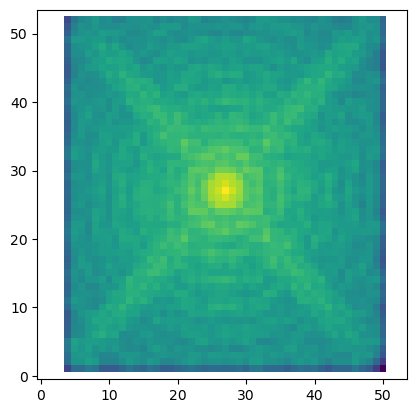

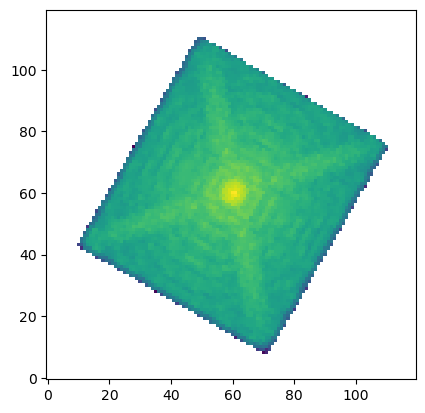

In [58]:
from astropy.wcs import WCS
#import lognorm
from matplotlib.colors import LogNorm
# test:
obj = obj_lis[0]
with fits.open(f"psf/individual_psf/{obj['subfield']}_{obj['id']}_ha.fits") as hdu:
    print(f"{obj['subfield']}_{obj['id']}_ha.fits")
    ha = hdu[3].data

ha = fits.ImageHDU(data = ha)
plt.imshow(ha.data, norm = LogNorm(), origin='lower')
plt.show()
pixelscale = 0.15
size = pixelscale * ha.data.shape[0]
#make a central concentrated image for ha
updated_header, ha_wcs = make_wcsheader(ra=150,dec=20,size=size,pixscale=pixelscale,theta=30)
ha.header.update(updated_header)
ha_wcs = WCS(updated_header)

num10 = 6
target_wcs = make_wcsheader(ra=150,dec=20,size=2*num10,pixscale=0.1,theta=0)[1]
weight_maps = np.ones_like(ha.data, dtype=np.float32)  # Ensure weights are float32
temp_ha_single = np.zeros((20*num10,20*num10), dtype=np.float32)
temp_ha_wht_single = np.zeros((20*num10,20*num10), dtype=np.float32)
temp_ha_con_single = np.zeros((20*num10,20*num10), dtype=np.int32)


adrizzle.do_driz(
            insci= ha.data,
            input_wcs= ha_wcs,
            inwht= weight_maps,
            output_wcs= target_wcs,
            outsci=temp_ha_single,
            outwht=temp_ha_wht_single,
            outcon=temp_ha_con_single,
            in_units='cps',
            expin=1.0,
            wt_scl=1.0,
            wcslin_pscale=1,
            pixfrac=0.8,#ha_drizzled.header['PIXFRAC'],
            kernel='square',
            fillval=0.0)


plt.imshow(temp_ha_single, origin='lower', norm = LogNorm())
plt.show()